# **Cloning the repository**

In [ ]:
!git clone https://github.com/naina-bhalla/PIXEL_PERSONA.git

fatal: destination path 'PIXEL_PERSONA' already exists and is not an empty directory.


In [ ]:
%ls

 Volume in drive C is Windows
 Volume Serial Number is E6E3-610C

 Directory of C:\Users\naina

12-12-2024  10:30    <DIR>          .
15-09-2024  18:36    <DIR>          ..
02-12-2024  19:41    <DIR>          .anaconda
10-08-2024  11:56    <DIR>          .arduinoIDE
09-08-2024  14:58    <DIR>          .cache
02-12-2024  19:49    <DIR>          .conda
02-12-2024  19:42               146 .condarc
02-12-2024  19:41    <DIR>          .continuum
30-11-2024  11:20                63 .gitconfig
05-08-2024  20:48    <DIR>          .gradle
11-08-2024  16:20    <DIR>          .idlerc
12-12-2024  10:24    <DIR>          .ipynb_checkpoints
02-12-2024  19:46    <DIR>          .ipython
11-12-2024  15:17    <DIR>          .jupyter
11-12-2024  23:58    <DIR>          .keras
09-08-2024  15:02    <DIR>          .m2
11-08-2024  16:21    <DIR>          .matplotlib
09-08-2024  14:58    <DIR>          .redhat
30-10-2024  11:01    <DIR>          .sonarlint
04-12-2024  10:05    <DIR>          .spyder-py3
26-11

# **Importing libraries and loading data into dataframe**

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout, Conv2D, MaxPooling2D,Activation,BatchNormalization

In [ ]:
import os
import zipfile
dataset_path = "PIXEL_PERSONA/Final_assignment/240674_NainaBhalla/Dataset/dataset.zip"
extracted_dir = "PIXEL_PERSONA/Final_assignment/240674_NainaBhalla/Dataset/dataset"  # Directory to extract to

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Update dataset path to the extracted directory
dataset_path = os.path.join(extracted_dir, 'dataset')
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')
validation_dir = os.path.join(dataset_path, 'validation')

**Adding labels to images in the datasets**

In [ ]:
from glob import glob
train_df = pd.DataFrame({"path":[],"label":[]}) #dataframe for training data
label_list = ['Male','Female',]

for i, label in enumerate(label_list):
    img_path = os.path.join(train_dir, label)
    img_list = glob(img_path+'/*.jpg')
    for img in img_list:
        new_data =pd.DataFrame({"path":img,"label":label}, index=[1])
        train_df = pd.concat([train_df, new_data], ignore_index=True)   #adding each image with its label to the dataframe

train_df[["path"]] = train_df[["path"]].astype(str)
train_df[["label"]] = train_df[["label"]].astype(str)

test_df=pd.DataFrame({"path":[],"label":[]})  #dataframe for testing data
for i, label in enumerate(label_list):
    img_path = os.path.join(test_dir, label)
    img_list = glob(img_path+'/*.jpg')
    for img in img_list:
        new_data =pd.DataFrame({"path":img,"label":label}, index=[1])
        test_df = pd.concat([test_df, new_data], ignore_index=True)

test_df[["path"]] = test_df[["path"]].astype(str)
test_df[["label"]] = test_df[["label"]].astype(str)

val_df=pd.DataFrame({"path":[],"label":[]})  #dataframe for validation data
for i, label in enumerate(label_list):
    img_path = os.path.join(validation_dir, label)
    img_list = glob(img_path+'/*.jpg')
    for img in img_list:
        new_data =pd.DataFrame({"path":img,"label":label}, index=[1])
        val_df = pd.concat([val_df, new_data], ignore_index=True)

val_df[["path"]] = val_df[["path"]].astype(str)
val_df[["label"]] = val_df[["label"]].astype(str)


# **Overview of training data**

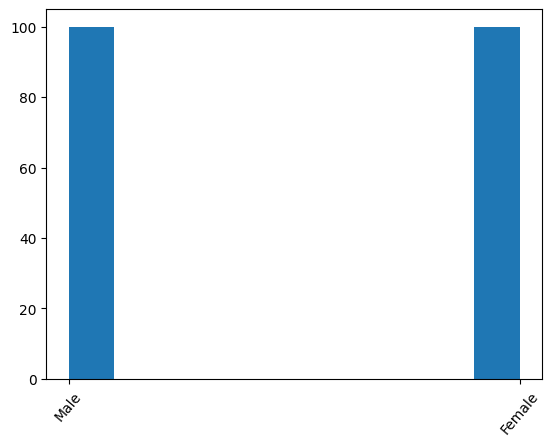

In [ ]:
#ratio of males and females in the training data
plt.hist(x = val_df["label"])
plt.xticks(rotation = 50);

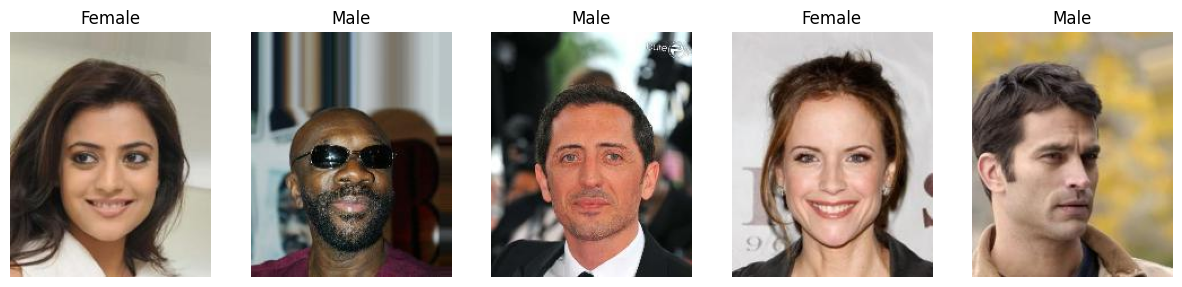

In [ ]:
# visualization of some data in the training dataset
show_imgs = 5
idx = np.random.randint(0, len(val_df),size=show_imgs)
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = val_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(val_df.loc[idx[i]]['label'])
    ax.set_axis_off()

In [ ]:
train_df.head()

,path,label
0,PIXEL_PERSONA/Final_assignment/240674_NainaBha...,Male
1,PIXEL_PERSONA/Final_assignment/240674_NainaBha...,Male
2,PIXEL_PERSONA/Final_assignment/240674_NainaBha...,Male
3,PIXEL_PERSONA/Final_assignment/240674_NainaBha...,Male
4,PIXEL_PERSONA/Final_assignment/240674_NainaBha...,Male


In [ ]:
# storing in X_train and y_train
X_train = train_df['path']
y_train = train_df['label']
X_test = test_df['path']
y_test = test_df['label']
X_val = val_df['path']
y_val = val_df['label']

# **Encoding and pre-processing the data**

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess images
def preprocess(image_paths):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=(96,96))  # Load image with target size
        img_array = img_to_array(img)  # Convert image to NumPy array
        img_array = img_array / 255.0  # Normalize pixel values
        images.append(img_array)
    return np.array(images)

# Load and preprocess training ,validation and testing data
X_train_processed = preprocess(X_train)
X_val_processed = preprocess(X_val)
X_test_processed = preprocess(X_test)

In [ ]:
#generates augmented data so the model does not memorize the training data exactly
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train_processed)

In [ ]:
#encoding the gender labelss with LabelEncoder
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)
y_test_encoded = label_encoder.fit_transform(y_test)

# **Defining the model**

In [ ]:
#adding callbacks to prevent overfitting
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
model=keras.Sequential([
    Conv2D(filters=64,kernel_size=3,input_shape=(96,96,3),padding="same",activation='relu'),     #padding so the kernel reads the boudaries properly
    MaxPooling2D(pool_size=2),        #to decrease computational time by reducing the number of pixels
    Dropout(0.35),                    #to reduce overfiiting by dropping 35% of random neurons in the layer(0.35 giving best accuracy and least loss)

    Conv2D(filters=64,kernel_size=3,padding="same",activation='relu'),
    Conv2D(filters=64,kernel_size=3,padding="same",activation='relu'),
    BatchNormalization(),             #to scale the model to give better generalization
    MaxPooling2D(pool_size=2),
    Dropout(0.35),

    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.45),
    Dense(1,activation='sigmoid')

])
#compiling the model with adam optimizer and binary_crossentropy
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy']
              )
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 96, 96, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       4,718,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,794,753 (18.29 MB)

 Trainable params: 4,794,625 (18.29 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
#fitting the model with training data
history = model.fit(X_train_processed,y_train_encoded,
                    epochs=20,
                    verbose=1,
                    batch_size=10,
                    validation_data=(X_val_processed,y_val_encoded),
                    callbacks=[early_stopping]
                    )

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - binary_accuracy: 0.5688 - loss: 4.0189 - val_binary_accuracy: 0.6350 - val_loss: 0.6675
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - binary_accuracy: 0.7294 - loss: 0.5824 - val_binary_accuracy: 0.5600 - val_loss: 0.6303
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - binary_accuracy: 0.7374 - loss: 0.5964 - val_binary_accuracy: 0.6300 - val_loss: 0.6396
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - binary_accuracy: 0.7822 - loss: 0.4768 - val_binary_accuracy: 0.7300 - val_loss: 0.5376
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - binary_accuracy: 0.8135 - loss: 0.4162 - val_binary_accuracy: 0.7750 - val_loss: 0.4817
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - binary_accuracy: 0.8804 - loss: 0.3069 - val_binary_accuracy: 0.8600 - val_loss: 0.3465
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - binary_accuracy: 0.9128 - loss: 0.2383 - val_binary_accuracy: 0.8600 - val_loss: 0.4232
Epoch 8/20
90

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - binary_accuracy: 0.8765 - loss: 0.3172
Loss =  0.30173465609550476
Accuracy =  88.49999904632568 %


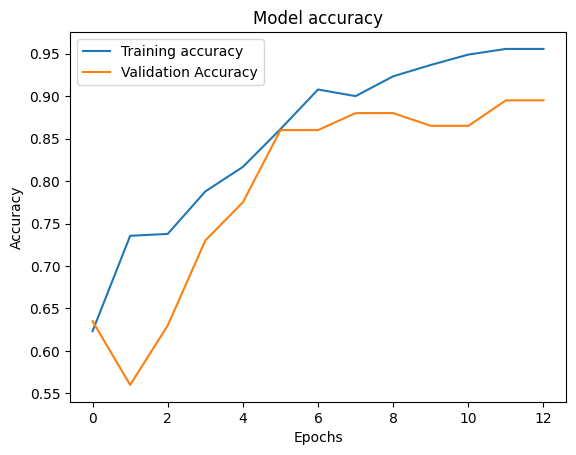

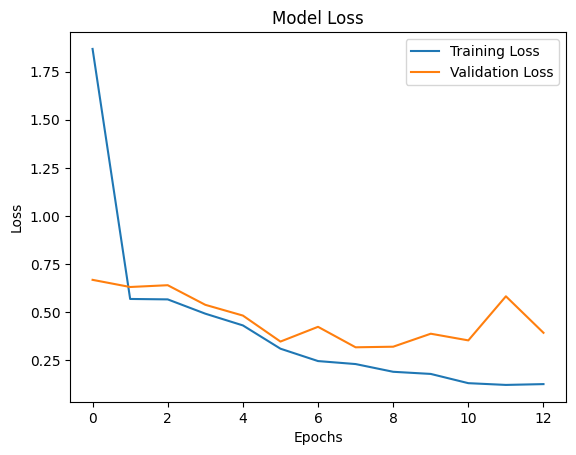

In [ ]:
# printing loss and accuracy on test data
results = model.evaluate(X_test_processed,y_test_encoded)
print("Loss = ",results[0])
print("Accuracy = ",results[1]*100,"%")

#plotting training and validation accuracy vs epochs
plt.plot(history.history['binary_accuracy'], label="Training accuracy")
plt.plot(history.history['val_binary_accuracy'], label="Validation Accuracy")
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#plotting training and validation loss vs epochs
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# **Importing Haar Cascades**

In [ ]:
import os
import zipfile
haar_path = "PIXEL_PERSONA/Final_assignment/240674_NainaBhalla/Dataset/archive.zip"
extracted = "PIXEL_PERSONA/Final_assignment/240674_NainaBhalla/Dataset/archive"  # Directory to extract to

with zipfile.ZipFile(haar_path, 'r') as zip_ref:
    zip_ref.extractall(extracted)

# Update dataset path to the extracted directory
haar_path = os.path.join(extracted, 'archive')

# **Final Predictions**

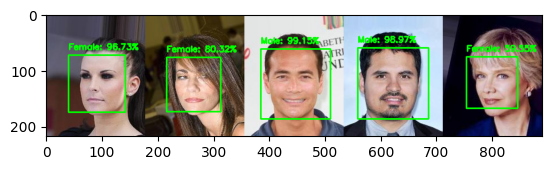

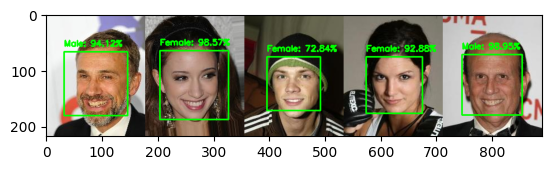

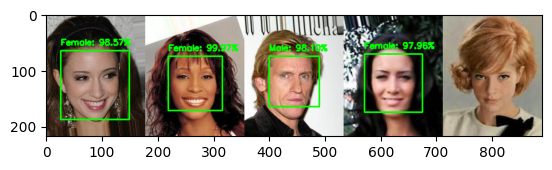

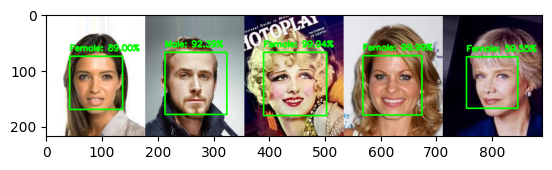

In [ ]:
import cv2
import numpy as np
import random
from keras.models import load_model
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow

f_cascade = cv2.CascadeClassifier("PIXEL_PERSONA/Final_assignment/240674_NainaBhalla/Dataset/archive/haarcascade_frontalface_default.xml")  #defining haar cascades for face detection
gender_labels = ["Male", "Female"]

# Function to test the model on random images
def test_model(image):

        image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        faces = f_cascade.detectMultiScale(image, 1.3, 5)   #detecting the 4 points in the image using haar cascades
        for idx, f in enumerate(faces):   #using the points
          x,y = f[0], f[1]
          w,h = f[2], f[3]

          # draw rectangle over face
          cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0), 2)

          # preprocessing for gender detection model
          face_crop = cv2.resize(image, (96,96))
          face_crop = face_crop.astype("float32") / 255.0
          face_crop = np.expand_dims(face_crop, axis=0)

          # apply gender detection on face
          conf = model.predict(face_crop,verbose=0)[0]
          # get label with max accuracy
          idx = np.argmax(conf)
          label = gender_labels[idx]
          if conf[idx] > 0.5:
            label = "Male"
          else:
            label = "Female"
            conf[idx]=1-conf[idx]

          label = "{}: {:.2f}%".format(label, conf[idx] * 100)

          Y = y - 10 if y - 10 > 10 else y + 10

          # write label and confidence above face rectangle
          cv2.putText(image, label, (x,Y),  cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 255, 0), 2)

        # Display or save the processed image
        #cv2_imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        return image

# Test the model on 20 random images

for j in range(4):
  images=[]
  for i in range(5):
    idx = np.random.randint(0, len(X_test_processed))
    full_path = X_test.iloc[idx]
    image=cv2.imread(full_path)
    images.append(test_model(image))
  concatenated_images = np.concatenate(images, axis=1)   #to plot the images using least space in output window
  b,g,r = cv2.split(concatenated_images)
  frame_rgb = cv2.merge((r,g,b))
  plt.imshow(cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR))   #matplotlib used since cv2.imshow was not working
  plt.show()
  #cv2.imshow('Gender Predictions',cv2.cvtColor(concatenated_images, cv2.COLOR_RGB2BGR))




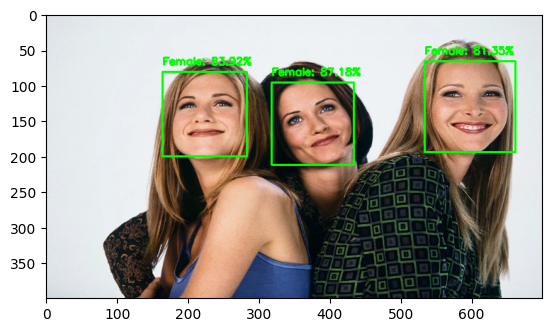

In [ ]:
#testing on an image with multiple faces
image=cv2.imread('PIXEL_PERSONA/Final_assignment/240674_NainaBhalla/Rachel-Monica-and-Phoebe.webp')
image=cv2.resize(image,(700,400))
image=test_model(image)
b,g,r = cv2.split(image)
frame_rgb = cv2.merge((r,g,b))
plt.imshow(cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR))   #matplotlib used since cv2.imshow was not working
plt.show()

# **Live Model**

**It detects the face of the person using the webcam and then predicts their gender**


This portion only works when a local runtime is used

In [ ]:
webcamera = cv2.VideoCapture(0)
f_cascade = cv2.CascadeClassifier("PIXEL_PERSONA/Final_assignment/240674_NainaBhalla/Dataset/archive/haarcascade_frontalface_default.xml")  #defining haar cascades for face detection
gender_labels = ["Male", "Female"]


while True:
    success, image = webcamera.read()
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    faces = f_cascade.detectMultiScale(image, 1.3, 5)   #detecting the 4 points in the image using haar cascades
    for idx, f in enumerate(faces):   #using the points
          x,y = f[0], f[1]
          w,h = f[2], f[3]

          # draw rectangle over face
          cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0), 2)

          # preprocessing for gender detection model
          face_crop = cv2.resize(image, (96,96))
          face_crop = face_crop.astype("float32") / 255.0
          face_crop = np.expand_dims(face_crop, axis=0)

          # apply gender detection on face
          conf = model.predict(face_crop,verbose=0)[0]
          # get label with max accuracy
          idx = np.argmax(conf)
          label = gender_labels[idx]
          if conf[idx] > 0.5:
            label = "Male"
          else:
            label = "Female"
            conf[idx]=1-conf[idx]

          label = "{}: {:.2f}%".format(label, conf[idx] * 100)

          Y = y - 10 if y - 10 > 10 else y + 10

          # write label and confidence above face rectangle
          cv2.putText(image, label, (x,Y),  cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 255, 0), 2)

        # Display or save the processed image
          cv2.imshow("Gender Predictions",cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    if cv2.waitKey(1) & 0xFF == ord("q"):
             break

webcamera.release()
cv2.destroyAllWindows()
